In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import MDAnalysis as mda

# More advanced analysis

This notebook shows examples of a few more complicated analyses. There is way more available in the library. *MDAnalysis* uses a consistent paradigm for its analyses, meaning that if you understand the examples below, you should be well prepared to run whatever analyses you need. For a description of how it works, check out the [Analyis User Guide](https://userguide.mdanalysis.org/stable/examples/analysis/README.html). 

The following cell is a generic trajectory loader. Just change the value of `trajectory_dir` to load different directories. 

In [3]:
trajectory_dir = "output"

import glob
import os

xtc_files = glob.glob(os.path.join(trajectory_dir,"traj-split*.xtc"))
xtc_files.sort()
univ = mda.Universe(os.path.join(trajectory_dir,"traj.gro"),
                    xtc_files,
                    guess_bonds=True)

This cell calculates the RMSD of the protein backbone over the simulation. Note the paradigm: 

1. Make selection (`backbone = univ.select_atoms("protein and backbone")`)
2. Create analysis object (`r = rms.RMSD(backbone)`)
3. Run the analysis (`r.run(verbose=True)`)
4. Grab results from `results` attribute (`df = np.array(r.results["rmsd"])`)
5. Plot/do further analyses.

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0, 0.5, 'RMSD')

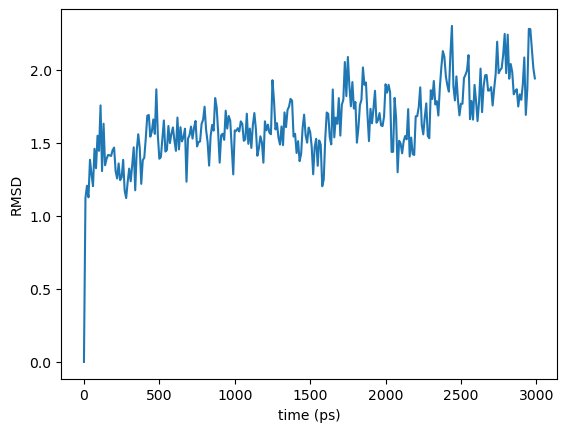

In [4]:
from MDAnalysis.analysis import rms

backbone = univ.select_atoms("protein and backbone")
r = rms.RMSD(backbone)
r.run(verbose=True)

df = pd.DataFrame(r.results["rmsd"])
df.columns = ["frame","time","rmsd"]

plt.plot(df["time"],df["rmsd"])
plt.xlabel("time (ps)")
plt.ylabel("RMSD")

If you want more information about how to use a given function, you can use the `help` command:

In [5]:
help(rms.RMSD)

Help on class RMSD in module MDAnalysis.analysis.rms:

class RMSD(MDAnalysis.analysis.base.AnalysisBase)
 |  RMSD(atomgroup, reference=None, select='all', groupselections=None, weights=None, weights_groupselections=False, tol_mass=0.1, ref_frame=0, **kwargs)
 |
 |  Class to perform RMSD analysis on a trajectory.
 |
 |  The RMSD will be computed for two groups of atoms and all frames in the
 |  trajectory belonging to `atomgroup`. The groups of atoms are obtained by
 |  applying the selection selection `select` to the changing `atomgroup` and
 |  the fixed `reference`.
 |
 |  Note
 |  ----
 |  If you use trajectory data from simulations performed under **periodic
 |  boundary conditions** then you *must make your molecules whole* before
 |  performing RMSD calculations so that the centers of mass of the selected
 |  and reference structure are properly superimposed.
 |
 |
 |  Run the analysis with :meth:`RMSD.run`, which stores the results
 |  in the array :attr:`RMSD.results.rmsd`.
 |


Using nearly identical syntax, we can also calculate the root-mean-squared fluctuation of the CA atoms over the simulation. This code assumes that the protein structure has been aligned across frames. Fortunately, this is true for us because of how we extracted our simulations after running GROMACS.  

Text(0, 0.5, 'RMSF')

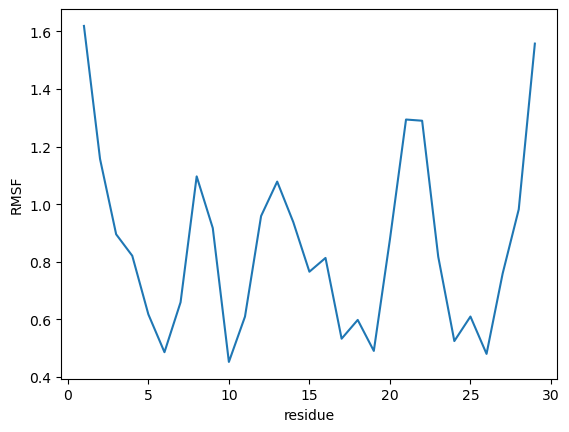

In [6]:
from MDAnalysis.analysis import rms

ca_atoms = univ.select_atoms("protein and name CA")
r = rms.RMSF(ca_atoms)
r.run()

plt.plot(ca_atoms.resids,
         r.results["rmsf"])
plt.xlabel("residue")
plt.ylabel("RMSF")
                         

This is a more complicated example, but shows the sorts of things that are possible. We are using the built-in hydrogen bonds analysis package to look for hydrogen bonds that are donated by water and accepted by protein N or O atoms. When I wrote this, I had to figure out how to parse the `hb.results["hbonds"]` output using the [documentation](https://docs.mdanalysis.org/stable/documentation_pages/analysis/hydrogenbonds.html). 

In [7]:
from MDAnalysis.analysis import hydrogenbonds

protein = univ.select_atoms("protein")
hb = hydrogenbonds.HydrogenBondAnalysis(univ,
                                        hydrogens_sel="name H* and resname SOL",
                                        acceptors_sel="protein and type N O",
                                        d_a_cutoff=3.0,
                                        d_h_a_angle_cutoff=150,
                                        update_selections=True)

# COOL FEATURE: I can select which frames to analyze here (only 10-20 for speed
# in the example)
hb.run(verbose=True,
       start=10,
       stop=20)

# Convert results into a dataframe
df = pd.DataFrame(hb.results["hbonds"])
df.columns = ["frame","donor","hydrogen","acceptor","distance","angle"]
df["donor"] = np.array(df["donor"],dtype=int)
df["hydrogen"] = np.array(df["hydrogen"],dtype=int)
df["acceptor"] = np.array(df["acceptor"],dtype=int)

# Create a "bond" column that has (donor,acceptor) and thus uniquely
# identifies row as coming from this bond
df["bond"] = list(zip(df.donor,df.acceptor))
df

  0%|          | 0/10 [00:00<?, ?it/s]

,frame,donor,hydrogen,acceptor,distance,angle,bond
0,10.0,446,447,350,2.624956,155.952824,"(446, 350)"
1,10.0,446,448,222,2.605321,169.962614,"(446, 222)"
2,10.0,548,550,276,2.742445,156.162595,"(548, 276)"
3,10.0,1361,1362,409,2.598943,172.421147,"(1361, 409)"
4,10.0,1859,1861,360,2.776579,160.206998,"(1859, 360)"
...,...,...,...,...,...,...,...
526,19.0,12218,12219,299,2.608851,150.027067,"(12218, 299)"
527,19.0,12302,12304,102,2.703868,155.535160,"(12302, 102)"
528,19.0,12350,12351,299,2.683916,159.033749,"(12350, 299)"
529,19.0,12389,12391,372,2.800232,176.214646,"(12389, 372)"


Text(0, 0.5, 'frequency')

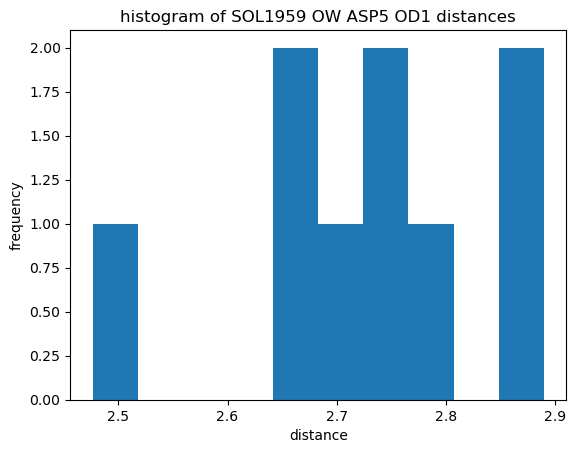

In [8]:
# Get the bond seen the most number of times
bonds, counts = np.unique(df["bond"],return_counts=True)
most_seen_bond = bonds[counts == np.max(counts)][0]

donor = univ.atoms[most_seen_bond[0]]
donor_name = f"{donor.resname}{donor.resid} {donor.name}"

acceptor = univ.atoms[most_seen_bond[1]]
acceptor_name = f"{acceptor.resname}{acceptor.resid} {acceptor.name}"

most_common_bond_df = df.loc[df.bond == most_seen_bond,:]
plt.hist(most_common_bond_df["distance"])
plt.title(f"histogram of {donor_name} {acceptor_name} distances")
plt.xlabel("distance")
plt.ylabel("frequency")

